# Training without time consideration

In [56]:
import pandas as pd
data = pd.read_csv('../data/data_preprocessed.csv')

In [57]:


input = [col for col in data.columns if col not in {'Wind speed (m/s)', 'Date'}]

X, y = data[input], data['Wind speed (m/s)']

# Splitting the data into training and testing data but use the fisrt 80% of the data for training and the rest for testing
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]


In [58]:
X_train.shape

(70154, 9)

In [59]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from skopt.space import Real, Categorical, Integer

n_col = X_train.shape[1]

dict_models = [
    {
        'name_model': 'Gradient_Boosting',
        'model': GradientBoostingRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__n_estimators': Integer(10, 300),
            'model__max_depth': Integer(1, n_col),
            'model__learning_rate': Real(0.01, 1),
        },
    },

    {
        'name_model': 'Random_Forest',
        'model': RandomForestRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__n_estimators': Integer(10, 300),
            'model__max_depth': Integer(1, n_col),
        },
    },

    {
        'name_model': 'Decision_Tree',
        'model': DecisionTreeRegressor(random_state=42),
        'scalers': {
            'scaler': Categorical([None]),
        },
        'grid': {
            'model__max_depth': Integer(1, n_col),
        },
        
    },

    {
        'name_model': 'Linear_Regression',
        'model': LinearRegression(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid': {},
    },

    {
        'name_model': 'Ridge',
        'model': Ridge(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()]),
        },
        'grid': {
            'model__alpha': Real(0.0001, 10000),
        },
    },

    {
        'name_model': 'KNN',
        'model': KNeighborsRegressor(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()])
        },
        'grid': {
            'model__n_neighbors': Integer(1, 20)
        },
    },
    {
        'name_model': 'Lasso',
        'model': Lasso(),
        'scalers': {
            'scaler': Categorical([None, MinMaxScaler(), StandardScaler()])
        },
        'grid': {
            'model__alpha': Real(0.0001, 10000),
        },
    },
]

In [60]:
import numpy as np
print(np.__version__)

1.22.1


In [61]:
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from time import time
from utils import model_evaluation_lr
import os
import pickle

import warnings
warnings.filterwarnings("ignore")

results = pd.DataFrame(columns=["Model", "CPU time", "RMSE", "R2"])
models = {}
nb_res = 0

for i, dict_model in enumerate(dict_models):
    model_name = dict_model['name_model']
    path_model = f"../pickle/models/{model_name}.pkl"
    path_time = f"../pickle/cpu_time/{model_name}_time.pkl"
    if not os.path.exists(path_model) or not os.path.exists(path_time):
        print(f'Training {model_name}...')

        model = dict_model['model']

        steps = [
            ('scaler', None),
            ('model', model),
        ]

        pipeline = Pipeline(steps)

        param_grid = {
            **dict_model['scalers'],
            **dict_model['grid']
        }

        model = BayesSearchCV(pipeline, search_spaces=param_grid, cv=5, n_jobs=-1, scoring='r2', n_iter=20, random_state=42)

        start_time = time()
        model.fit(X_train, y_train)
        end_time = time()
        duration = round(end_time - start_time)
        print(f"CPU Time: {duration}s")

        with open(path_model, 'wb') as f:
            pickle.dump(model, f)

        with open(path_time, 'wb') as f:
            pickle.dump(duration, f)
    
    else:
        with open(path_model, 'rb') as f:
            model = pickle.load(f)

        with open(path_time, 'rb') as f:
            duration = pickle.load(f)

    print(f"Best params {model_name}: \n{model.best_params_}")

    y_pred = model.predict(X_test)
    eval = model_evaluation_lr(y_test, y_pred)
    
    models[model_name] = model

    results.loc[nb_res] = [model_name, duration, eval['rmse'], eval['r2']]
    nb_res += 1

    print()

Training Gradient_Boosting...
CPU Time: 252s
Best params Gradient_Boosting: 
OrderedDict([('model__learning_rate', 0.013594004182195795), ('model__max_depth', 8), ('model__n_estimators', 225), ('scaler', None)])

Training Random_Forest...
CPU Time: 239s
Best params Random_Forest: 
OrderedDict([('model__max_depth', 9), ('model__n_estimators', 300), ('scaler', None)])

Training Decision_Tree...
CPU Time: 6s
Best params Decision_Tree: 
OrderedDict([('model__max_depth', 8), ('scaler', None)])

Training Linear_Regression...
CPU Time: 5s
Best params Linear_Regression: 
OrderedDict([('scaler', None)])

Training Ridge...
CPU Time: 5s
Best params Ridge: 
OrderedDict([('model__alpha', 0.0001), ('scaler', MinMaxScaler())])

Training KNN...
CPU Time: 15s
Best params KNN: 
OrderedDict([('model__n_neighbors', 20), ('scaler', StandardScaler())])

Training Lasso...
CPU Time: 6s
Best params Lasso: 
OrderedDict([('model__alpha', 0.0001), ('scaler', None)])



## Results

In [62]:
print(results.to_string(index=False))

            Model  CPU time  RMSE    R2
Gradient_Boosting       252 0.558 0.799
    Random_Forest       239 0.566 0.793
    Decision_Tree         6 0.583 0.780
Linear_Regression         5 0.600 0.767
            Ridge         5 0.600 0.767
              KNN        15 0.604 0.764
            Lasso         6 0.606 0.763


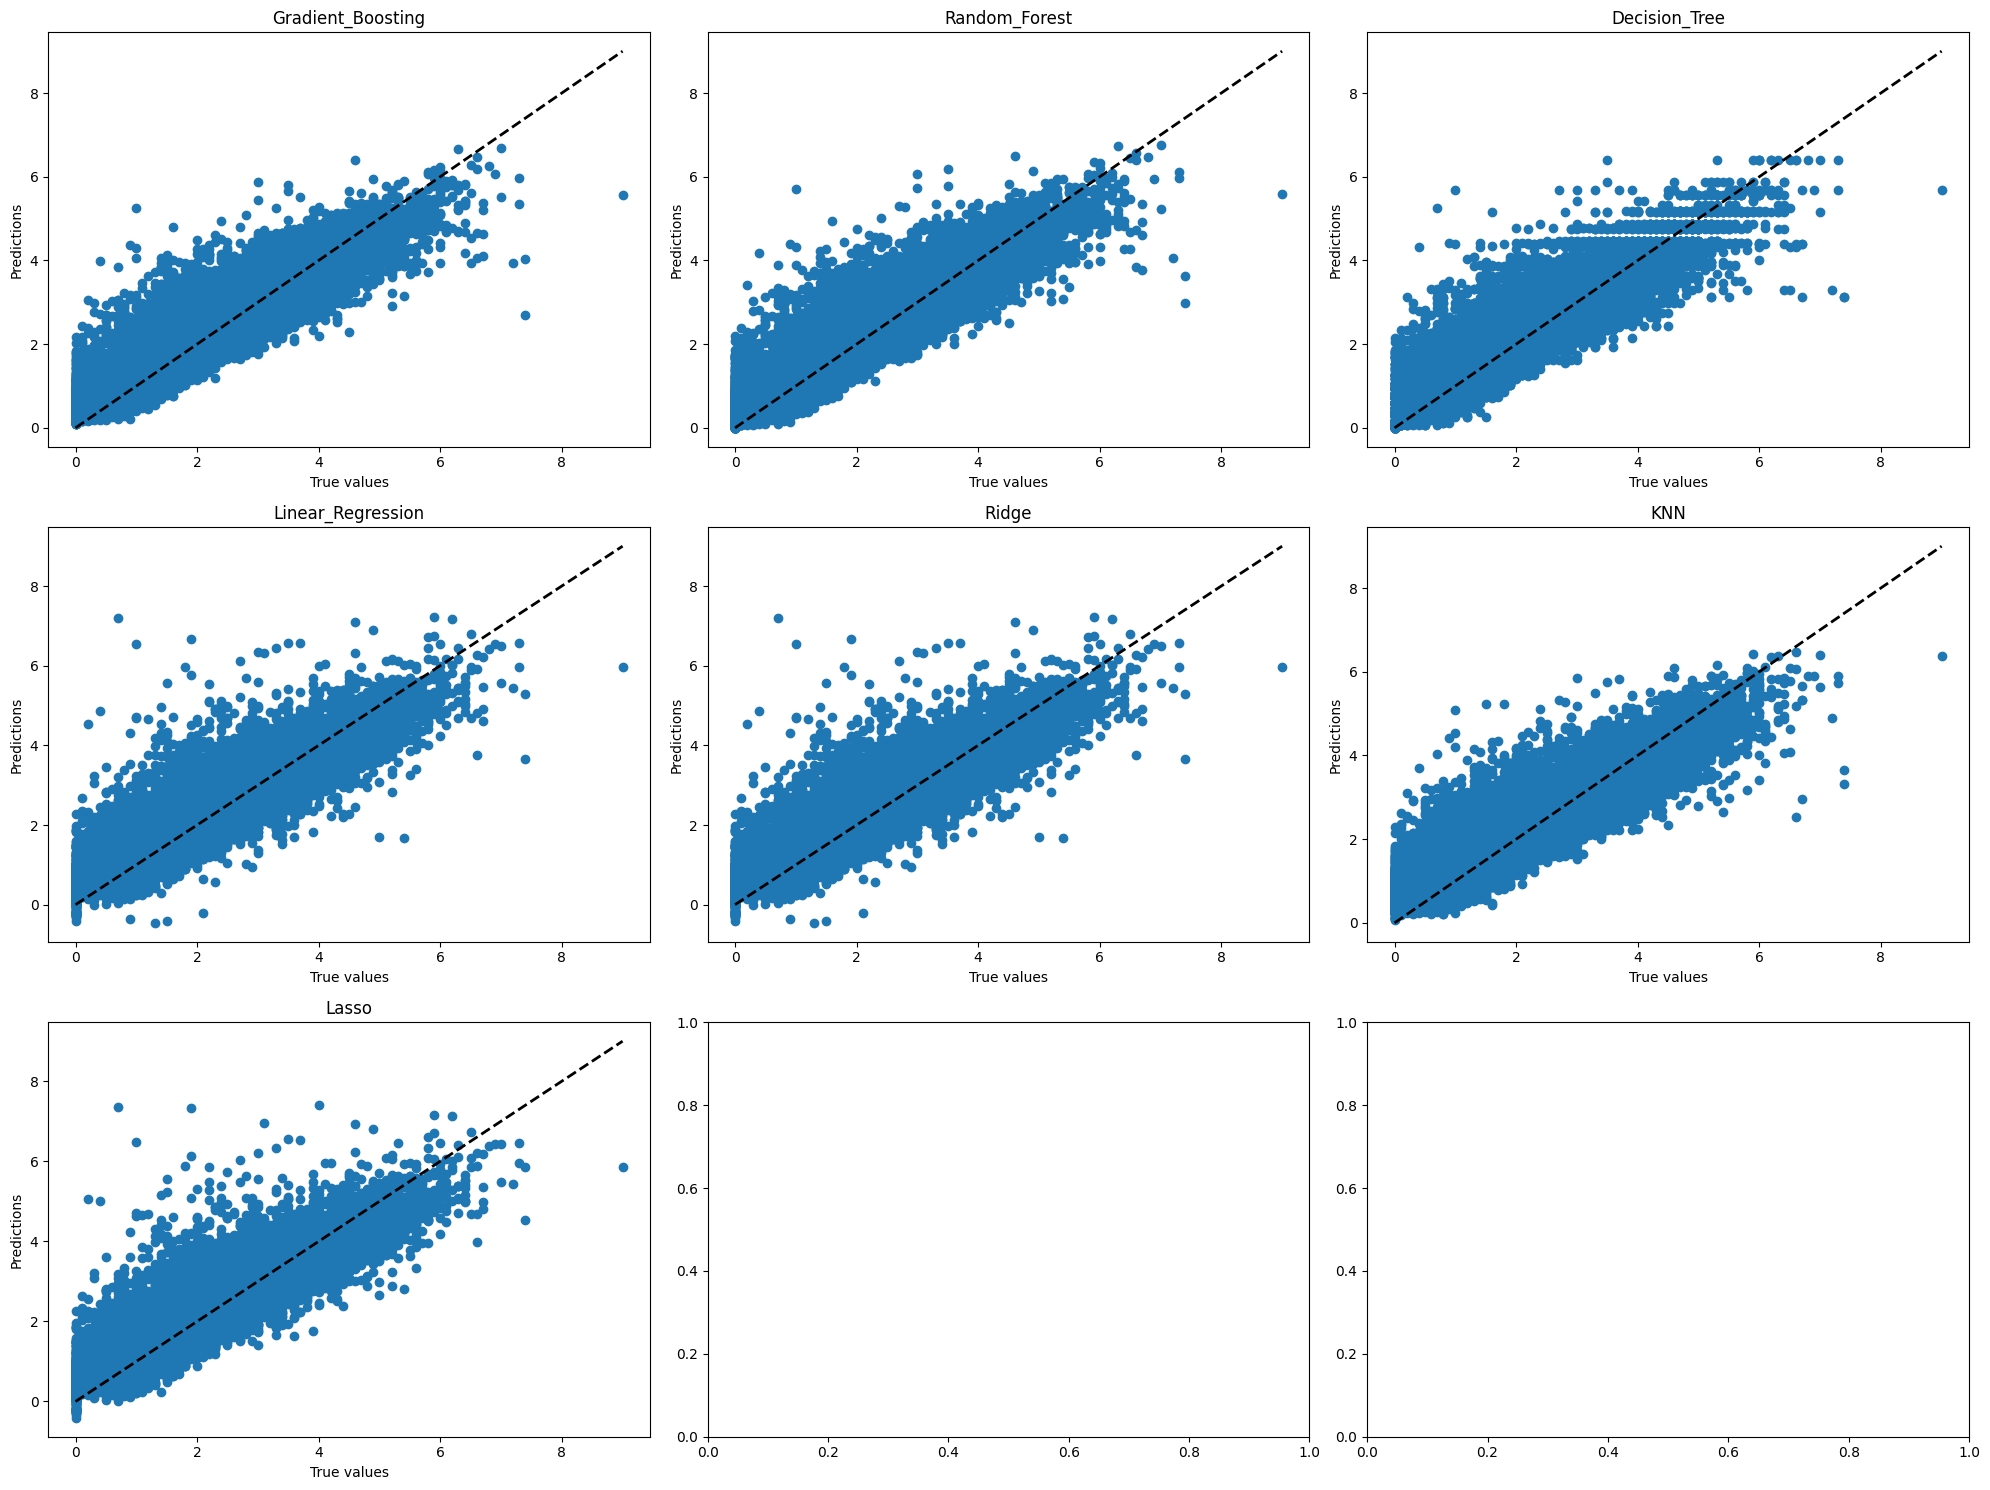

In [63]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.flatten()

for i, model_name in enumerate(models.keys()):
    model = models[model_name]
    y_pred = model.predict(X_test)

    axs[i].plot([0, y_test.max()], [0, y_test.max()], 'k--', lw=2)
    axs[i].scatter(y_test, y_pred)
    axs[i].set_xlabel('True values')
    axs[i].set_ylabel('Predictions')
    axs[i].set_title(model_name)

plt.tight_layout()
plt.show()

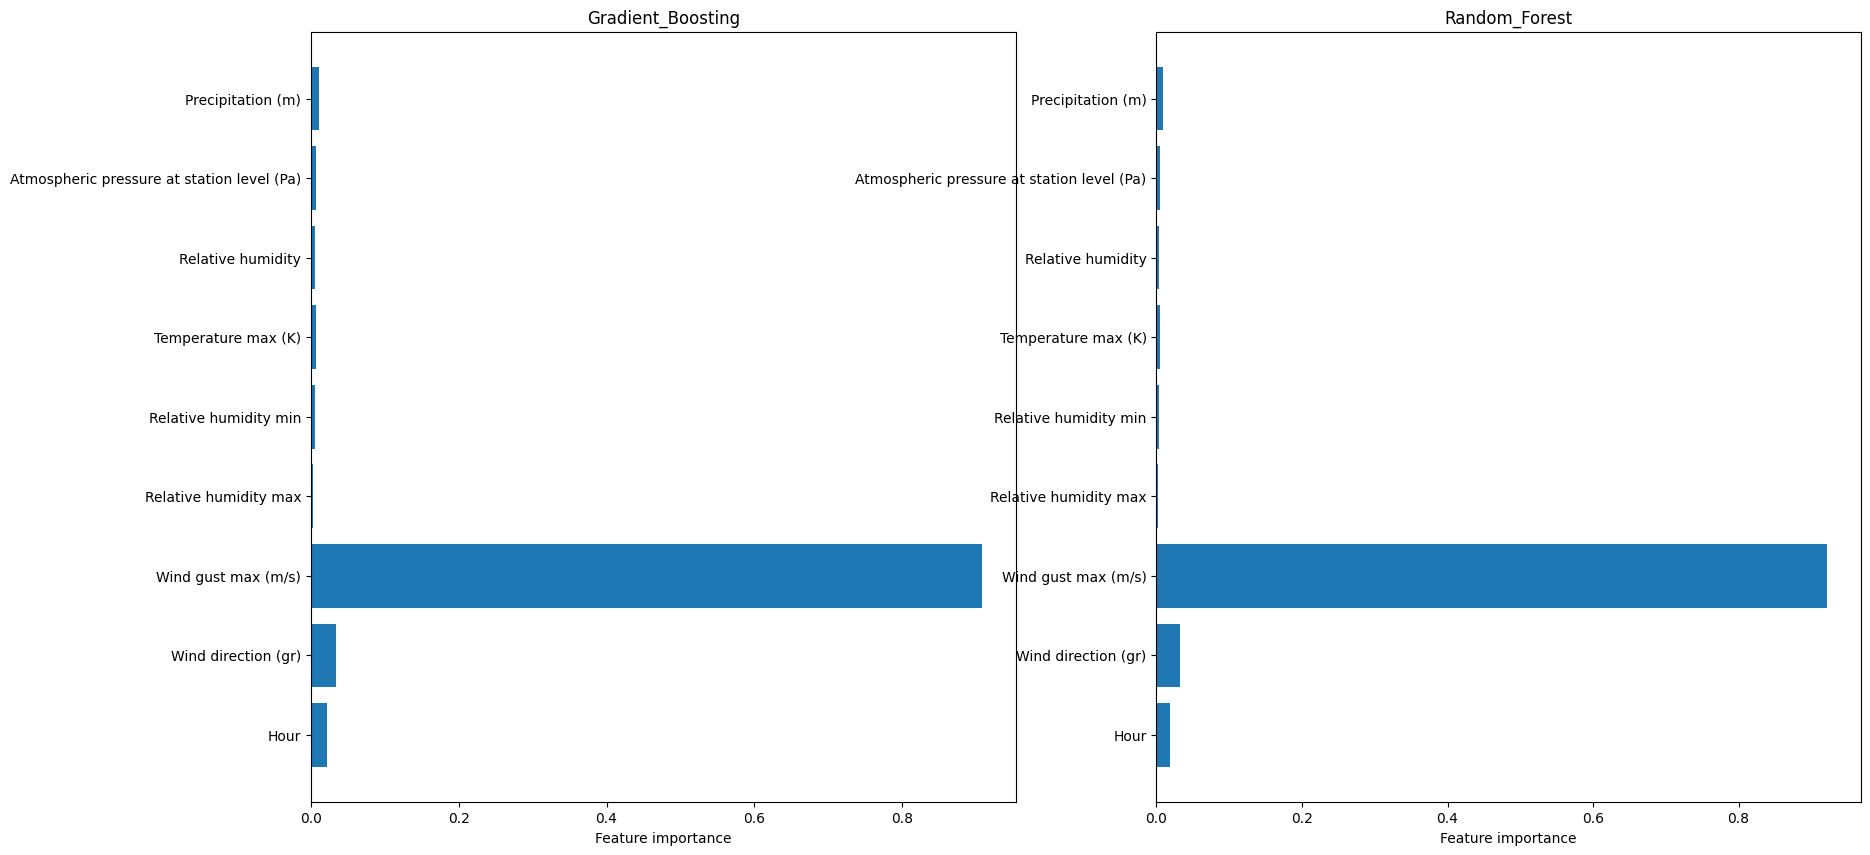

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs = axs.flatten()

for i, model_name in enumerate(['Gradient_Boosting', 'Random_Forest']):
    model = models[model_name]
    if model_name == 'Gradient_Boosting':
        feature_importance = model.best_estimator_['model'].feature_importances_
    else:
        feature_importance = model.best_estimator_['model'].feature_importances_

    axs[i].barh(X_train.columns, feature_importance)
    axs[i].set_xlabel('Feature importance')
    axs[i].set_title(model_name)

plt.show()
